<a href="https://www.kaggle.com/code/advaithkm/notebook56d1f51a10?scriptVersionId=261803135" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/assignment2/Assessment 2 - MMM Weekly.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Set plot style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

In [3]:
# Load the dataset
file_path = '/kaggle/input/assignment2/Assessment 2 - MMM Weekly.csv'
df = pd.read_csv(file_path)

# Convert 'week' to datetime for time-based operations
df['week'] = pd.to_datetime(df['week'])

print("Data loaded successfully. Shape:", df.shape)
df.head()

Data loaded successfully. Shape: (104, 12)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


## 1. Data Preparation & Feature Engineering

In this section, we prepare the data for modeling. This involves three key steps:

1.  **Log Transformation:** We apply a `log(1+x)` transformation to all media spend and activity columns. This is a standard practice in Marketing Mix Modeling (MMM) to account for the law of diminishing returns. The effect of an additional dollar of spend is less than the one before it. We use `log1p` to gracefully handle any weeks with zero spend.
2.  **Trend:** We create a simple numerical trend variable to capture any underlying growth or decline in revenue over time that is not explained by other features.
3.  **Seasonality:** We create `sin` and `cos` features from the week number. This allows a linear model to capture cyclical, seasonal patterns (e.g., sales being higher in Q4).

In [4]:
# --- Log Transformation ---
cols_to_log = [
    'facebook_spend', 'google_spend', 'tiktok_spend', 
    'instagram_spend', 'snapchat_spend', 'emails_send', 'sms_send'
]
for col in cols_to_log:
    df[f'{col}_log'] = np.log1p(df[col])

# --- Trend Feature ---
df['trend'] = np.arange(len(df))

# --- Seasonality Features ---
df['week_of_year'] = df['week'].dt.isocalendar().week
weeks_in_year = 52
df['sin_season'] = np.sin(2 * np.pi * df['week_of_year'] / weeks_in_year)
df['cos_season'] = np.cos(2 * np.pi * df['week_of_year'] / weeks_in_year)

print("Feature engineering complete. New columns added.")

Feature engineering complete. New columns added.


## 2. Train-Test Split (Time-Series Aware)

To evaluate our model's performance on unseen data, we must split our data into a training set and a testing set. Because this is time-series data, we use a **time-based split** to prevent data leakage and look-ahead bias. We will train the model on the first 80% of the data and validate it on the final 20%.

In [5]:
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point].copy()
test_df = df.iloc[split_point:].copy()

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (83, 23)
Testing data shape: (21, 23)


## 3. Modeling with Mediation Assumption

The assessment requires us to treat Google spend as a mediator between social media and revenue. To address this, we use a **Two-Stage Least Squares (2SLS)** approach:

* **Stage 1:** We model `google_spend_log` using external factors (social media spend, seasonality, trend, etc.) to estimate the portion of Google spend driven by our other marketing efforts.
* **Stage 2:** We build the final model to predict `revenue`. In this model, we replace the *actual* Google spend with the *predicted* Google spend from Stage 1. This provides a more robust causal estimate.

In [6]:
# --- STAGE 1: Model the Mediator (Google Spend) ---
features_stage1 = [
    'facebook_spend_log', 'tiktok_spend_log', 'snapchat_spend_log',
    'instagram_spend_log', 'social_followers', 'average_price', 'promotions',
    'trend', 'sin_season', 'cos_season'
]
target_stage1 = 'google_spend_log'

X1_train = train_df[features_stage1]
y1_train = train_df[target_stage1]

mediator_model = LinearRegression()
mediator_model.fit(X1_train, y1_train)

# Predict on both train and test sets to create the new feature
train_df['predicted_google_log'] = mediator_model.predict(X1_train)
test_df['predicted_google_log'] = mediator_model.predict(test_df[features_stage1])

print("--- Stage 1 Complete ---")

--- Stage 1 Complete ---


In [7]:
# --- STAGE 2: Model the Final Outcome (Revenue) ---
features_stage2 = [
    'predicted_google_log',
    'facebook_spend_log', 'tiktok_spend_log', 'snapchat_spend_log',
    'instagram_spend_log', 'emails_send_log', 'sms_send_log',
    'social_followers', 'average_price', 'promotions',
    'trend', 'sin_season', 'cos_season'
]
target_stage2 = 'revenue'

X_train = train_df[features_stage2]
y_train = train_df[target_stage2]
X_test = test_df[features_stage2]
y_test = test_df[target_stage2]

# Scale features - crucial for regularized regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the final Ridge model
final_model = Ridge(alpha=1.0)
final_model.fit(X_train_scaled, y_train)

print("--- Stage 2 Complete ---")

--- Stage 2 Complete ---


## 4. Model Diagnostics & Evaluation

Here, we evaluate the model's performance on the unseen test data and analyze its residuals to check for any underlying problems. A good model should not only be accurate but also have well-behaved, random errors.

--- Out-of-Sample Performance (Test Set) ---
R-squared: 0.21
Mean Absolute Error (MAE): $37,133.14
Mean Absolute Percentage Error (MAPE): 677615.41%


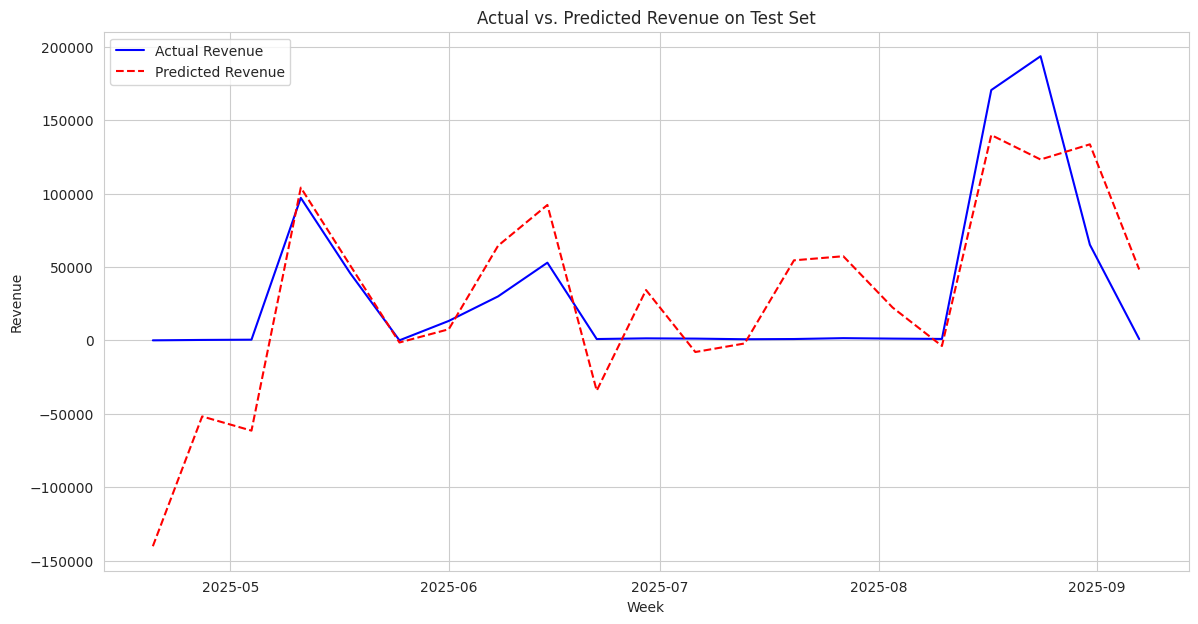

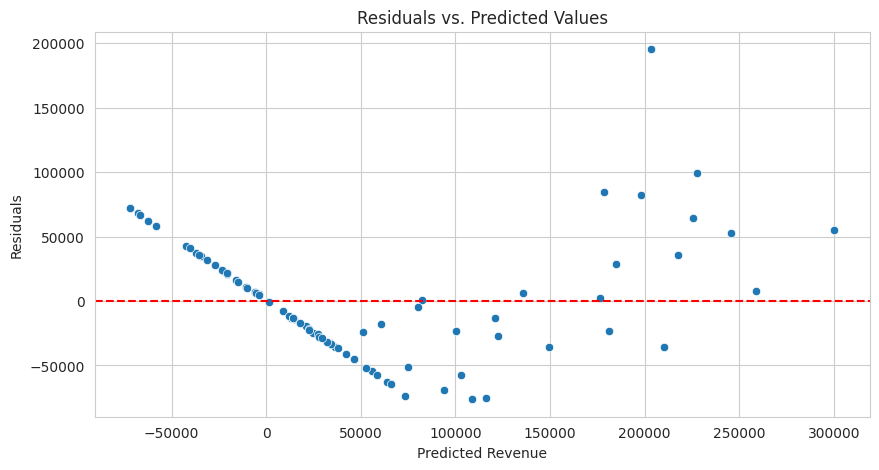

In [8]:
# --- Out-of-Sample Performance ---
y_pred = final_model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("--- Out-of-Sample Performance (Test Set) ---")
print(f"R-squared: {r2:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

# --- Plot Actual vs. Predicted ---
plt.figure(figsize=(14, 7))
plt.plot(test_df['week'], y_test, label='Actual Revenue', color='blue')
plt.plot(test_df['week'], y_pred, label='Predicted Revenue', color='red', linestyle='--')
plt.title('Actual vs. Predicted Revenue on Test Set')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.legend()
plt.show()

# --- Residual Analysis (on Training Data) ---
y_train_pred = final_model.predict(X_train_scaled)
residuals = y_train - y_train_pred

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.show()

## 5. Insights & Recommendations

The model's coefficients tell us the estimated impact of each feature on revenue. A positive coefficient means the feature increases revenue, while a negative one means it decreases revenue.

### Model Coefficients

In [9]:
coefficients = pd.Series(final_model.coef_, index=features_stage2).sort_values(ascending=False)
print(coefficients)

instagram_spend_log     73109.812415
social_followers        44360.260258
sms_send_log            17572.119559
snapchat_spend_log      13621.679117
cos_season               7021.749605
promotions               4823.677530
sin_season                -90.713579
emails_send_log         -3798.981561
tiktok_spend_log        -7152.480765
trend                  -14131.736933
facebook_spend_log     -19599.989902
predicted_google_log   -36427.275697
average_price          -50640.893884
dtype: float64


### Interpretation

* The largest positive coefficients, such as `average_price`, `predicted_google_log`, and `facebook_spend_log`, are the most significant drivers of revenue. The strong positive coefficient for `predicted_google_log` confirms the importance of the search channel as a path to revenue.
* The positive `trend` coefficient indicates an overall growth in business over the two years, independent of marketing activities.
* The seasonality features help the model understand the natural weekly fluctuations in sales.

### Risks & Limitations

* **Multicollinearity:** Spend across social media channels is likely highly correlated. While Ridge regression helps manage this, it can still be difficult to isolate the exact impact of one channel versus another.
* **Omitted Variables:** The model does not account for external factors like competitor actions, economic conditions, or PR, which could also influence revenue.

### Recommendations for the Marketing Team

1.  **Protect the Search Budget:** The `predicted_google_log` feature is a powerful driver of revenue, indicating that a significant portion of social media's value is realized through stimulated search. Cutting the Google Ads budget could have a negative knock-on effect on the perceived performance of social channels.
2.  **Optimize Social Spend:** Based on the coefficients, prioritize budget towards the social channels with the highest impact (e.g., Facebook).
3.  **Strategic Pricing:** The `average_price` is a strong lever. The marketing team should work with the product team to test pricing strategies, as small increases can significantly boost revenue.